In [1]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [3]:
#|default_exp agents.dqn.dueling

In [4]:
#|export
# Python native modules
import os
from collections import deque
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch.utils.data.dataloader_experimental import DataLoader2
from torch.utils.data.datapipes._typing import _DataPipeMeta, _IterDataPipeMeta
from torchdata.dataloader2.graph import find_dps,traverse,DataPipe,replace_dp,remove_dp
# Local modules
import torch
from torch.nn import *
import torch.nn.functional as F
from torch.optim import *

from fastrl.torch_core import *

from fastrl.core import *
from fastrl.agents.core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.memory.experience_replay import *
from fastrl.agents.core import *
from fastrl.agents.discrete import *
from fastrl.loggers.core import *
from fastrl.loggers.vscode_visualizers import *
from fastrl.learner.core import *
from fastrl.agents.dqn.basic import *
from fastrl.agents.dqn.target import *
from fastrl.agents.dqn.double import *
from fastrl.agents.dqn.dueling import *
from fastrl.agents.dqn.categorical import *

# DQN Rainbow
> Combines target, dueling, double, categorical dqns

> Important: I think this also needs special exploration layers also to be officially a rainbow implimentation

In [6]:
from fastrl.envs.gym import *
from fastrl.agents.dqn.target import *
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
model = CategoricalDQN( # CategoricalDQN
    4,2,
    head_layer=DuelingHead # DuelingDQN
).to(device='cuda')
# Setup the Agent
agent = DQNAgent(model,[logger_base],max_steps=4000,device='cuda',
                dp_augmentation_fns=[
                    MultiModelRunner.replace_dp(device='cuda') # CategoricalDQN
])
# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True), # We basically merge 2 steps into 1 and skip. 
    (GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True,n=100,include_images=True),VSCodeTransformBlock())
)
dls = L(block.dataloaders(['CartPole-v1']*1))
# Setup the Learner
learner = DQNLearner(model,dls,logger_bases=[logger_base],bs=128,
                     batches=1000,
                     loss_func = PartialCrossEntropy, # CategoricalDQN
                     device='cuda',
                     max_sz=100_000,
                     lr=0.001,
                     dp_augmentation_fns=[
                         TargetModelUpdater.insert_dp(),# TargetDQN
                         CategoricalTargetQCalc.replace_remove_dp( # CategoricalDQN
                             device='cuda',
                             nsteps=2,
                             double_dqn_strategy=True # DoubleDQN
                         )
                     ])
learner.fit(3)
# learner.fit(7)

loss,episode,rolling_reward,epoch,batch,epsilon
2.5539885,85,24.240000,1,1001,0.532500
1.9510038,102,55.200000,2,1001,0.038500
0.91924554,114,92.140000,2,1001,0.020000


/opt/conda/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


Creating gif from 100 frames


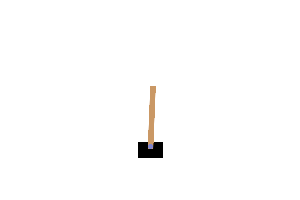

In [7]:
learner.validate()

In [8]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()

/opt/conda/lib/python3.7/site-packages/astroid/node_classes.py:96: DeprecationWarning: The 'astroid.node_classes' module is deprecated and will be replaced by 'astroid.nodes' in astroid 3.0.0
  DeprecationWarning,
